# Projet IA - HumanForYou
## Préparation et analyse des données
Ce notebook contient la préparation des données, l’analyse exploratoire (EDA) et la modélisation pour prédire l’attrition des employés.


## 1. Importation des librairies
Dans cette étape, nous importons toutes les librairies nécessaires pour :
- manipuler les données (pandas, numpy)
- faire des visualisations (matplotlib, seaborn)
- préparer et entraîner les modèles de Machine Learning (scikit-learn)


In [164]:
# =========================================================
# 1. Importation des librairies
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Modèles ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sns.set(style="whitegrid")


## 2. Chargement des données
Nous chargeons ici les différents fichiers CSV fournis :
- general_data : informations RH générales
- manager_survey_data : évaluations des managers
- employee_survey_data : satisfaction des employés
- in_time / out_time : heures d'arrivée et de départ (traité plus tard)

L’objectif est d’assembler l’ensemble des informations relatives à chaque employé.


In [165]:
general = pd.read_csv("data/general_data(1).csv")
manager = pd.read_csv("data/manager_survey_data.csv")
employee = pd.read_csv("data/employee_survey_data.csv")


Merge the datasets

In [166]:
df = general.merge(manager, on="EmployeeID", how="left")
df = df.merge(employee, on="EmployeeID", how="left")

df.head()


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


Inspect before cleaning

In [167]:
df.shape
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


Identify numeric and categorical columns

In [168]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

num_cols, cat_cols


(Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
        'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
        'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
        'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
        'YearsWithCurrManager', 'JobInvolvement', 'PerformanceRating',
        'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance'],
       dtype='object'),
 Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
        'JobRole', 'MaritalStatus', 'Over18'],
       dtype='object'))

Fill missing values properly

A) Numeric columns → median

In [169]:
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


Categorical columns → mode

In [170]:
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


###Drop useless columns

These 3 columns have NO VARIATION → useless for ML:

EmployeeCount (always 1)

StandardHours (always 8)

Over18 (always “Y”)

In [171]:
df = df.drop(["EmployeeCount", "StandardHours", "Over18"], axis=1)


Convert Attrition to numeric (0/1)

In [172]:
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})
df["Attrition"] = df["Attrition"].astype(int)


Final cleaning verification

In [173]:
print(df.isna().sum())      # MUST be all zeros
print(df.info())            # Attrition must be int64, useless columns removed
df.head()


Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
JobInvolvement             0
PerformanceRating          0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age          

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,0,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


## 3. Saving the Cleaned Dataset
After cleaning the dataset, we save it as a new CSV file so we can reuse it later without repeating all preprocessing steps. This ensures reproducibility and protects our work.


In [174]:
os.makedirs("clean_data", exist_ok=True)

df.to_csv("clean_data/clean_data.csv", index=False)

print("Cleaned dataset saved successfully as clean_data/clean_data.csv")

Cleaned dataset saved successfully as clean_data/clean_data.csv


## 4. Loading the Cleaned Dataset (Optional)
If we want to reuse the cleaned dataset later, we can load it directly without repeating the cleaning process.


In [175]:
df = pd.read_csv("clean_data/clean_data.csv")
df.head()


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,0,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


# 3. Exploratory Data Analysis (EDA)
In this section, we visualize the main features of the dataset to understand the distribution of variables and detect patterns related to employee attrition.


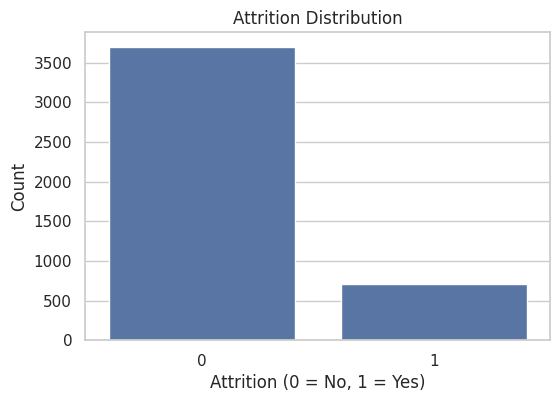

In [176]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Attrition"])
plt.title("Attrition Distribution")
plt.xlabel("Attrition (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


Most employees did not leave the company (Attrition = 0).  
This means the dataset is imbalanced, which will affect machine learning performance.


Cleaned dataset saved successfully as clean_data.csv


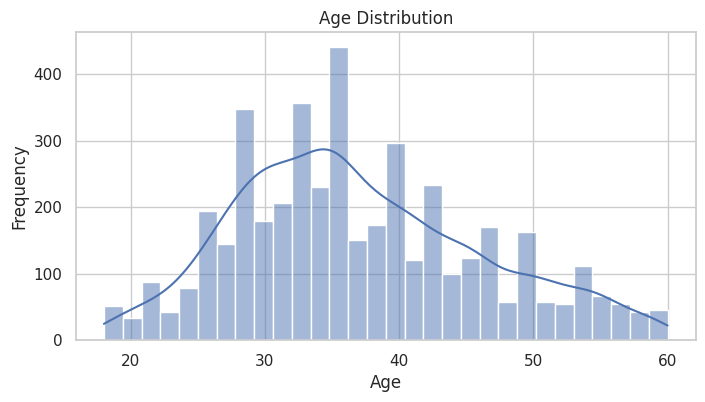

In [177]:
plt.figure(figsize=(8,4))
df.to_csv("clean_data/clean_data.csv", index=False)

print("Cleaned dataset saved successfully as clean_data.csv")

sns.histplot(df["Age"], kde=True, bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


The age distribution is concentrated between 30 and 40 years old.  
Understanding age distribution helps detect patterns related to attrition risk.


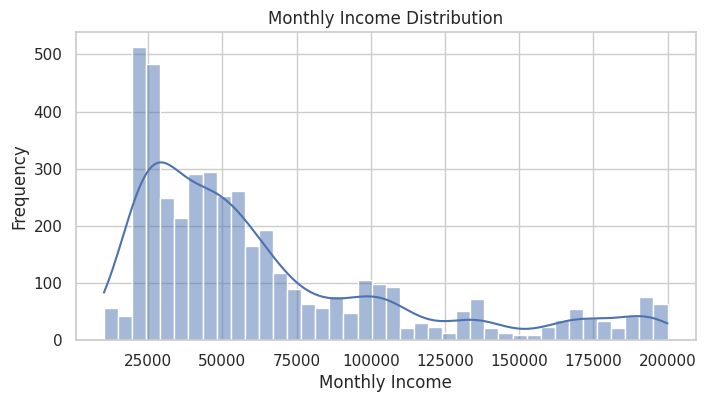

In [178]:
plt.figure(figsize=(8,4))
sns.histplot(df["MonthlyIncome"], kde=True, bins=40)
plt.title("Monthly Income Distribution")
plt.xlabel("Monthly Income")
plt.ylabel("Frequency")
plt.show()


Income is right-skewed, meaning most employees earn on the lower-middle range.  
This can help analyze if salary impacts attrition.


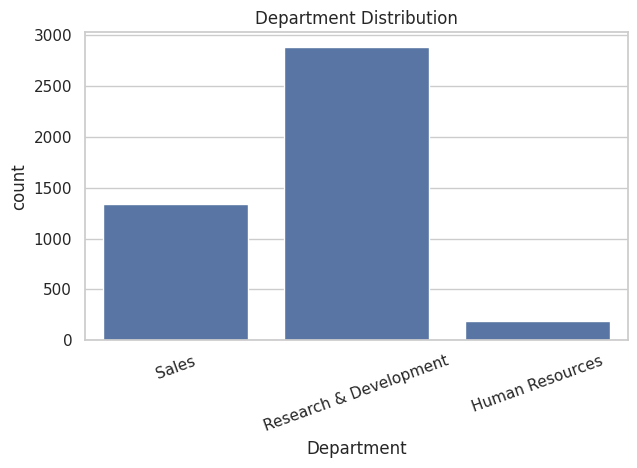

In [179]:
plt.figure(figsize=(7,4))
sns.countplot(x=df["Department"])
plt.title("Department Distribution")
plt.xticks(rotation=20)
plt.show()


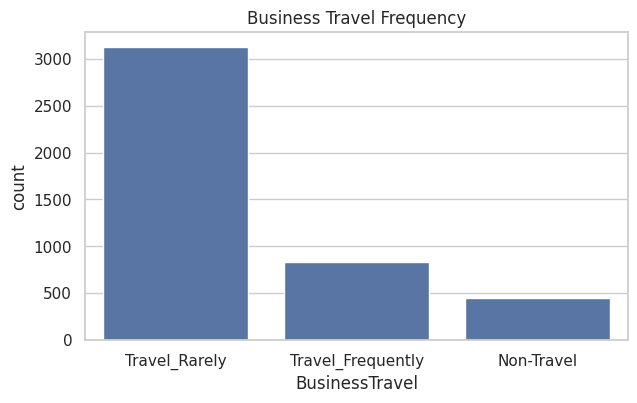

In [180]:
plt.figure(figsize=(7,4))
sns.countplot(x=df["BusinessTravel"])
plt.title("Business Travel Frequency")
plt.show()


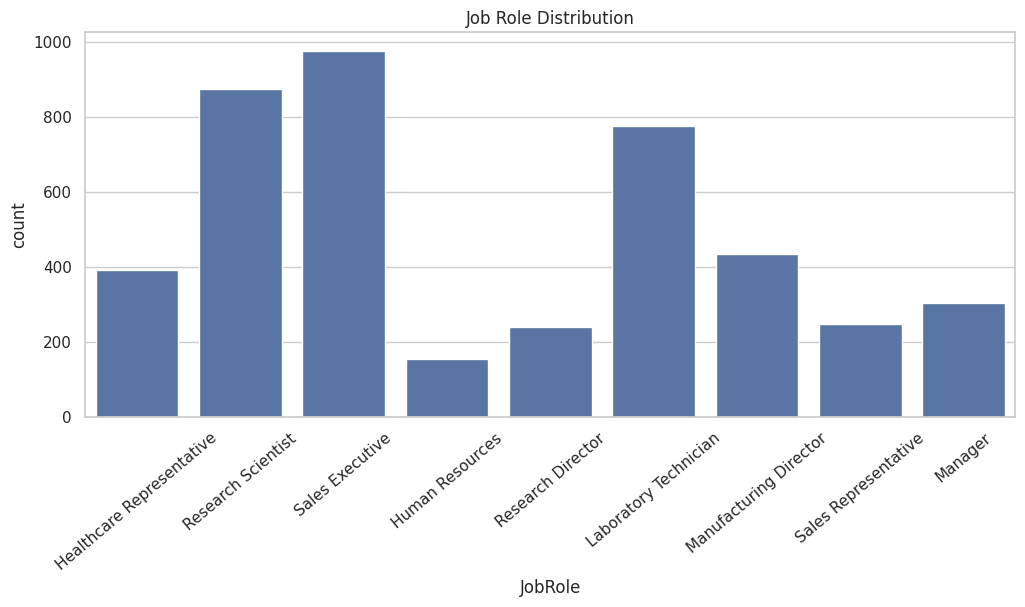

In [181]:
plt.figure(figsize=(12,5))
sns.countplot(x=df["JobRole"])
plt.title("Job Role Distribution")
plt.xticks(rotation=40)
plt.show()


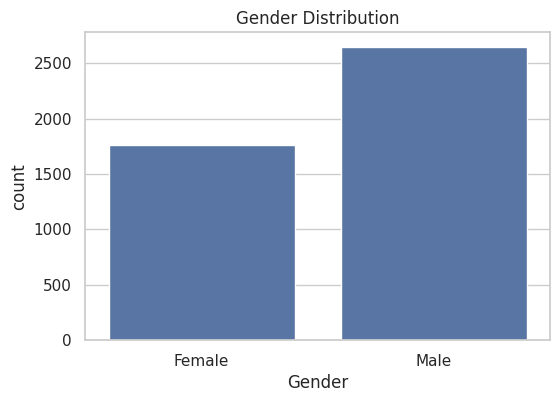

In [182]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Gender"])
plt.title("Gender Distribution")
plt.show()


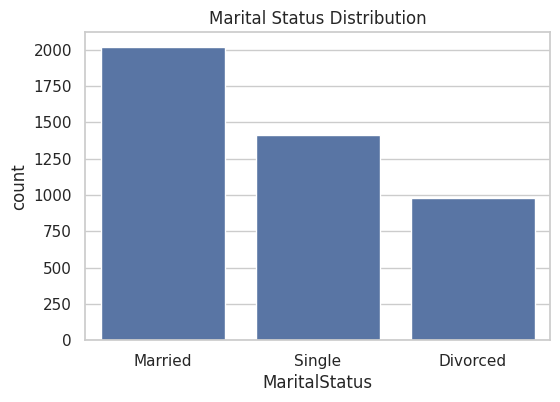

In [183]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["MaritalStatus"])
plt.title("Marital Status Distribution")
plt.show()


Categorical variable distributions show how employees are spread across roles, departments, gender, and travel frequency.  
These graphs help identify potential factors contributing to attrition.


#Correlation Heatmap

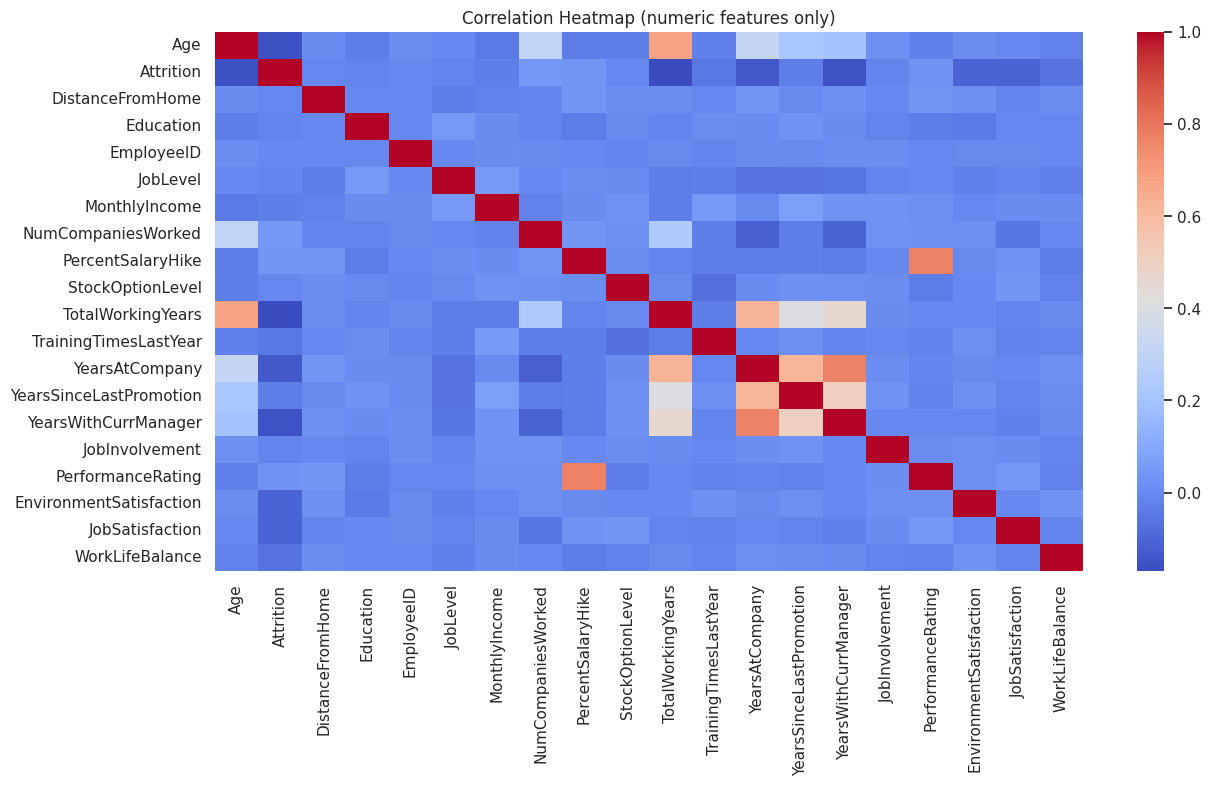

In [184]:
# ...existing code...
plt.figure(figsize=(14,7))
# option A: select numeric columns explicitly
corr = df.select_dtypes(include=[np.number]).corr()
# alternatively: corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (numeric features only)")
plt.show()
# ...existing code...

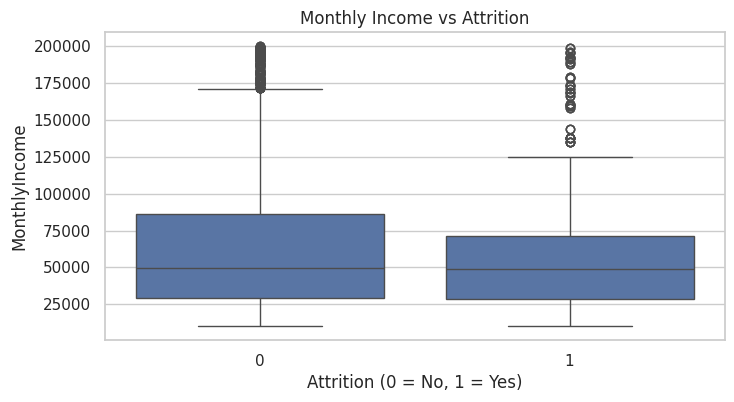

In [185]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Attrition"], y=df["MonthlyIncome"])
plt.title("Monthly Income vs Attrition")
plt.xlabel("Attrition (0 = No, 1 = Yes)")
plt.show()


Employees who left the company (Attrition = 1) may show different income distributions.  
Boxplots help detect patterns such as low salary → higher attrition.


Boxplot: YearsAtCompany vs Attrition

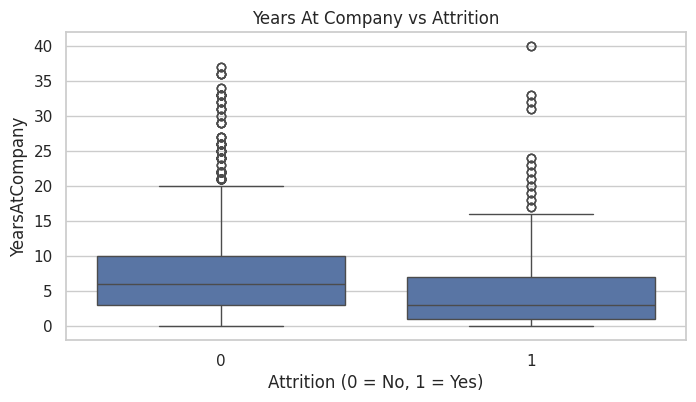

In [186]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Attrition"], y=df["YearsAtCompany"])
plt.title("Years At Company vs Attrition")
plt.xlabel("Attrition (0 = No, 1 = Yes)")
plt.show()


Employees with fewer years at the company tend to be more likely to leave early.  
This is a typical HR pattern, showing early turnover risk.


# 6 2️⃣ Prepare the data for Machine Learning

Split X and y

In [187]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]


Train-test split

In [188]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

now i will create the preprocessing pipeline : cuzz our dataframe has numeric columns (age , income ...) and categorical columne (gender ...)
the solution for this is ti use :

OneHotEncoder() → converts categories to numbers

StandardScaler() → normalizes numeric values

Identify numeric + categorical columns

In [189]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


Create the preprocessing pipeline

In [190]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


normaly after this preprocessing pipeline we can CHOOSE ML ALGORITHMS

In [191]:
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeID', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance'],
      dtype='object')
Categorical columns: Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus'],
      dtype='object')


that's mean that our preprocessing pipeline work ! it can classify collumns !!!

In [192]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [193]:
y_pred = model.predict(X_test)
print(y_pred[:10])

[0 0 0 1 0 0 0 1 0 0]


now we just completed:

✔ Data Cleaning



✔ Data Preparation


✔ EDA (Graphs)




✔ Train/Test Split




✔ Preprocessing Pipeline (StandardScaler + OneHotEncoder)




✔ Verification of transformation

 This means your dataset is 100% ML-ready.

# 7. Complete AI Solution for Employee Attrition Prediction
## Objective: Predict which employees will leave and identify the key factors driving attrition

In this section, we will:
1. Train multiple models with class imbalance handling
2. Compare model performance using comprehensive metrics
3. Identify the most important factors causing employees to leave
4. Create a prediction system to flag at-risk employees

## 7.1 Re-prepare Data with EmployeeID Removed

In [194]:
# Re-load cleaned data and prepare features
df = pd.read_csv("clean_data/clean_data.csv")

# Separate features and target
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Remove EmployeeID - it's an identifier, not a predictive feature
X = X.drop("EmployeeID", axis=1)

# Identify column types
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

print(f"Dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nClass imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1 (No:Yes)")

Dataset shape: (4410, 24)
Target distribution:
Attrition
0    3699
1     711
Name: count, dtype: int64

Class imbalance ratio: 5.20:1 (No:Yes)


In [195]:
# Train-test split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining target distribution:\n{y_train.value_counts()}")

Training set: 3528 samples
Test set: 882 samples

Training target distribution:
Attrition
0    2959
1     569
Name: count, dtype: int64


## 7.2 Build Preprocessing Pipeline

In [196]:
# Create preprocessing pipeline
# - StandardScaler for numeric columns (normalizes values)
# - OneHotEncoder for categorical columns (converts to binary features)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

print("Preprocessing pipeline created successfully!")
print(f"  - Numeric features ({len(num_cols)}): {list(num_cols)}")
print(f"  - Categorical features ({len(cat_cols)}): {list(cat_cols)}")

Preprocessing pipeline created successfully!
  - Numeric features (18): ['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
  - Categorical features (6): ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']


## 7.3 Train and Compare Multiple Models
We will test 4 different classification algorithms, all with `class_weight='balanced'` to handle the imbalanced dataset:
- **Logistic Regression**: Simple, interpretable baseline
- **Decision Tree**: Captures non-linear patterns
- **Random Forest**: Ensemble method, robust and accurate
- **Support Vector Machine (SVC)**: Good for complex decision boundaries

In [197]:
# Define models to compare - all with class_weight='balanced' to handle imbalanced data
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "SVM": SVC(class_weight='balanced', random_state=42, probability=True)
}

# Store results for comparison
results = {}

# Train and evaluate each model
for name, clf in models.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print('='*50)
    
    # Create pipeline with preprocessing + classifier
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results
    results[name] = {
        'pipeline': pipeline,
        'accuracy': accuracy,
        'precision_yes': report['1']['precision'],
        'recall_yes': report['1']['recall'],
        'f1_yes': report['1']['f1-score'],
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Attrition=Yes): {report['1']['precision']:.4f}")
    print(f"Recall (Attrition=Yes): {report['1']['recall']:.4f}")
    print(f"F1-Score (Attrition=Yes): {report['1']['f1-score']:.4f}")


Training: Logistic Regression
Accuracy: 0.7256
Precision (Attrition=Yes): 0.3188
Recall (Attrition=Yes): 0.6197
F1-Score (Attrition=Yes): 0.4211

Training: Decision Tree
Accuracy: 0.7256
Precision (Attrition=Yes): 0.3188
Recall (Attrition=Yes): 0.6197
F1-Score (Attrition=Yes): 0.4211

Training: Decision Tree
Accuracy: 0.9286
Precision (Attrition=Yes): 0.7135
Recall (Attrition=Yes): 0.9296
F1-Score (Attrition=Yes): 0.8073

Training: Random Forest
Accuracy: 0.9286
Precision (Attrition=Yes): 0.7135
Recall (Attrition=Yes): 0.9296
F1-Score (Attrition=Yes): 0.8073

Training: Random Forest
Accuracy: 0.9955
Precision (Attrition=Yes): 1.0000
Recall (Attrition=Yes): 0.9718
F1-Score (Attrition=Yes): 0.9857

Training: SVM
Accuracy: 0.9955
Precision (Attrition=Yes): 1.0000
Recall (Attrition=Yes): 0.9718
F1-Score (Attrition=Yes): 0.9857

Training: SVM
Accuracy: 0.9399
Precision (Attrition=Yes): 0.7697
Recall (Attrition=Yes): 0.8944
F1-Score (Attrition=Yes): 0.8274
Accuracy: 0.9399
Precision (Attrit

## 7.4 Model Comparison Visualization

In [198]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision_yes'] for m in results],
    'Recall': [results[m]['recall_yes'] for m in results],
    'F1-Score': [results[m]['f1_yes'] for m in results]
}).set_index('Model')

# Display comparison table
print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_df.round(4))

# Find best model based on F1-Score (balanced metric)
best_model_name = comparison_df['F1-Score'].idxmax()
print(f"\n🏆 Best Model (by F1-Score): {best_model_name}")

MODEL COMPARISON SUMMARY
                     Accuracy  Precision  Recall  F1-Score
Model                                                     
Logistic Regression    0.7256     0.3188  0.6197    0.4211
Decision Tree          0.9286     0.7135  0.9296    0.8073
Random Forest          0.9955     1.0000  0.9718    0.9857
SVM                    0.9399     0.7697  0.8944    0.8274

🏆 Best Model (by F1-Score): Random Forest


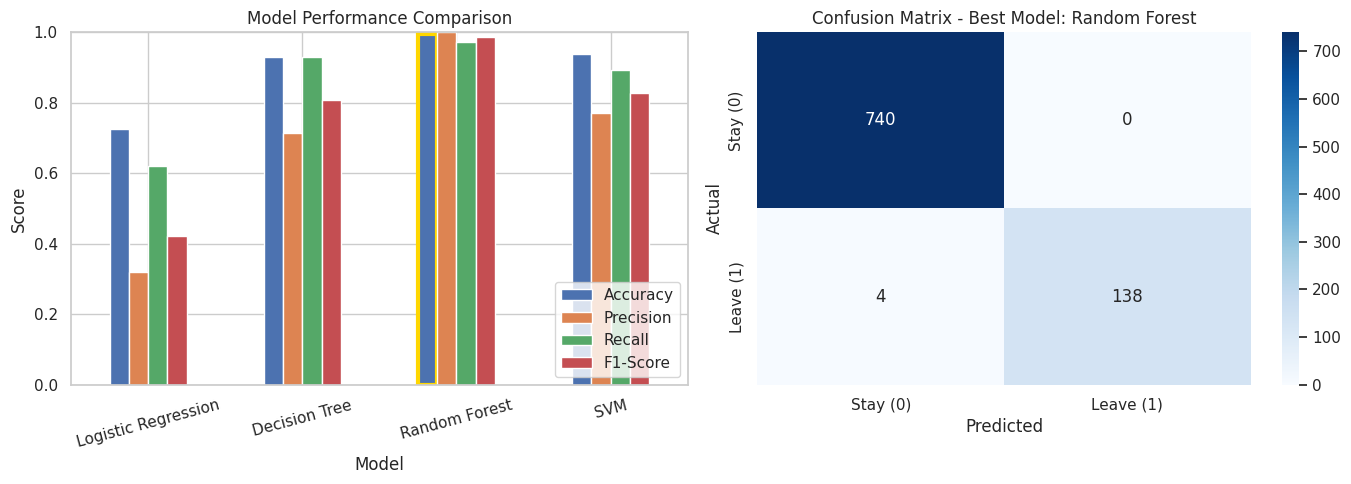

In [199]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of metrics
comparison_df.plot(kind='bar', ax=axes[0], rot=15)
axes[0].set_title('Model Performance Comparison')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)

# Highlight best model
for i, model in enumerate(comparison_df.index):
    if model == best_model_name:
        axes[0].patches[i].set_edgecolor('gold')
        axes[0].patches[i].set_linewidth(3)

# Confusion matrices for all models
axes[1].set_title('Confusion Matrix - Best Model: ' + best_model_name)
best_y_pred = results[best_model_name]['y_pred']
cm = confusion_matrix(y_test, best_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Stay (0)', 'Leave (1)'],
            yticklabels=['Stay (0)', 'Leave (1)'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [200]:
# Detailed classification report for best model
print(f"\n{'='*60}")
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print('='*60)
print(classification_report(y_test, results[best_model_name]['y_pred'], 
                           target_names=['Stay (No)', 'Leave (Yes)']))


DETAILED CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

   Stay (No)       0.99      1.00      1.00       740
 Leave (Yes)       1.00      0.97      0.99       142

    accuracy                           1.00       882
   macro avg       1.00      0.99      0.99       882
weighted avg       1.00      1.00      1.00       882



## 7.5 Feature Importance Analysis: Why Are Employees Leaving?
This is the most critical section - we identify the top factors driving employee attrition.

In [201]:
# Get feature names after preprocessing
# Fit the preprocessor to get feature names
preprocessor.fit(X_train)

# Get all feature names (numeric + one-hot encoded categorical)
numeric_features = list(num_cols)
categorical_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
all_feature_names = numeric_features + categorical_features

print(f"Total features after encoding: {len(all_feature_names)}")

Total features after encoding: 44


TOP 15 FACTORS DRIVING EMPLOYEE ATTRITION
(Based on Random Forest Feature Importance)
                Feature  Importance
                    Age    0.077312
          MonthlyIncome    0.072597
      TotalWorkingYears    0.072478
         YearsAtCompany    0.069238
       DistanceFromHome    0.053800
   YearsWithCurrManager    0.052015
      PercentSalaryHike    0.046355
     NumCompaniesWorked    0.042285
EnvironmentSatisfaction    0.039499
        JobSatisfaction    0.037163
  TrainingTimesLastYear    0.034538
YearsSinceLastPromotion    0.033445
   MaritalStatus_Single    0.027205
               JobLevel    0.027201
        WorkLifeBalance    0.026541


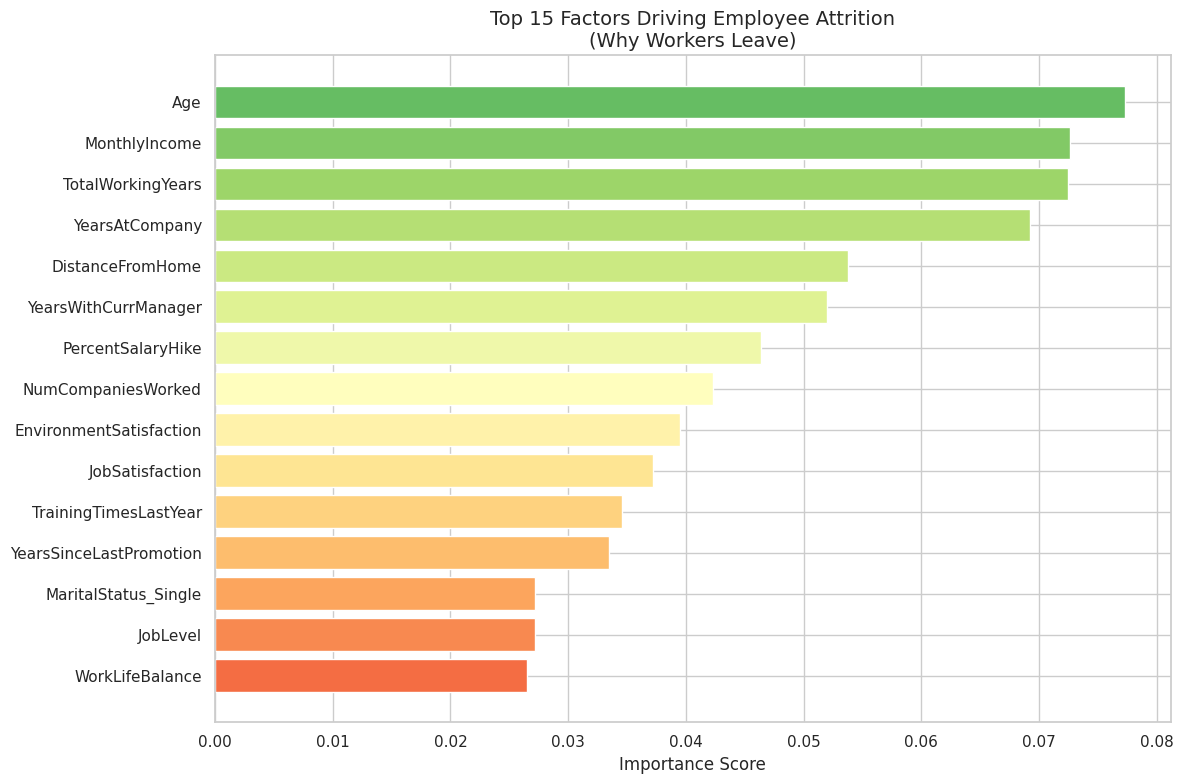

In [202]:
# Extract feature importance from Random Forest (most reliable)
rf_pipeline = results['Random Forest']['pipeline']
rf_importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

# Display top 15 most important features
print("="*60)
print("TOP 15 FACTORS DRIVING EMPLOYEE ATTRITION")
print("(Based on Random Forest Feature Importance)")
print("="*60)
print(importance_df.head(15).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_15 = importance_df.head(15)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, 15))
plt.barh(range(len(top_15)), top_15['Importance'].values, color=colors)
plt.yticks(range(len(top_15)), top_15['Feature'].values)
plt.xlabel('Importance Score')
plt.title('Top 15 Factors Driving Employee Attrition\n(Why Workers Leave)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [203]:
# Logistic Regression Coefficients - shows direction of impact
lr_pipeline = results['Logistic Regression']['pipeline']
lr_coefs = lr_pipeline.named_steps['classifier'].coef_[0]

# Create coefficient DataFrame
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': lr_coefs
})

# Separate positive (increases attrition) and negative (decreases attrition) factors
positive_factors = coef_df[coef_df['Coefficient'] > 0].sort_values('Coefficient', ascending=False).head(10)
negative_factors = coef_df[coef_df['Coefficient'] < 0].sort_values('Coefficient', ascending=True).head(10)

print("\n" + "="*60)
print("FACTORS THAT INCREASE ATTRITION RISK (Positive Coefficients)")
print("="*60)
print(positive_factors.to_string(index=False))

print("\n" + "="*60)
print("FACTORS THAT DECREASE ATTRITION RISK (Negative Coefficients)")
print("="*60)
print(negative_factors.to_string(index=False))


FACTORS THAT INCREASE ATTRITION RISK (Positive Coefficients)
                         Feature  Coefficient
  EducationField_Human Resources     0.964705
BusinessTravel_Travel_Frequently     0.734948
            MaritalStatus_Single     0.641205
         YearsSinceLastPromotion     0.485180
         JobRole_Sales Executive     0.386414
      Department_Human Resources     0.364017
              NumCompaniesWorked     0.317313
       JobRole_Research Director     0.226440
      JobRole_Research Scientist     0.212688
    JobRole_Sales Representative     0.166317

FACTORS THAT DECREASE ATTRITION RISK (Negative Coefficients)
                        Feature  Coefficient
      BusinessTravel_Non-Travel    -0.802297
 JobRole_Manufacturing Director    -0.632290
           YearsWithCurrManager    -0.627341
         MaritalStatus_Divorced    -0.508357
              TotalWorkingYears    -0.395573
       EducationField_Marketing    -0.374737
                JobSatisfaction    -0.369268
        En

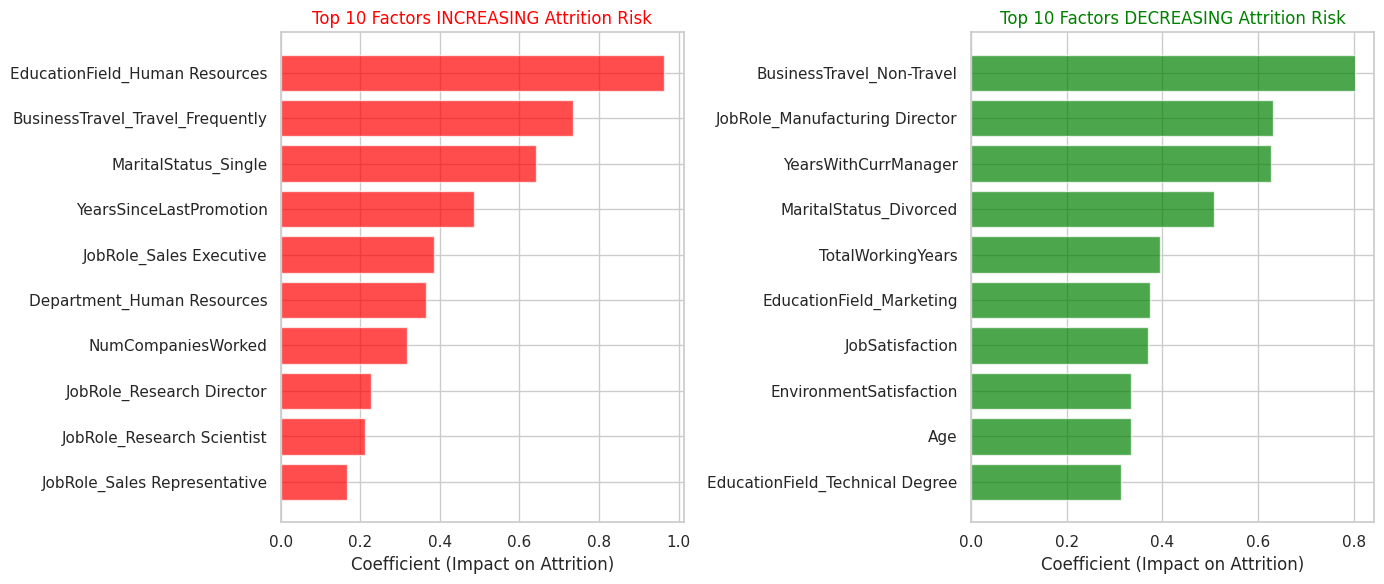

In [204]:
# Visualize coefficient impact
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top factors increasing attrition
axes[0].barh(range(len(positive_factors)), positive_factors['Coefficient'].values, color='red', alpha=0.7)
axes[0].set_yticks(range(len(positive_factors)))
axes[0].set_yticklabels(positive_factors['Feature'].values)
axes[0].set_xlabel('Coefficient (Impact on Attrition)')
axes[0].set_title('Top 10 Factors INCREASING Attrition Risk', fontsize=12, color='red')
axes[0].invert_yaxis()

# Top factors decreasing attrition
axes[1].barh(range(len(negative_factors)), negative_factors['Coefficient'].abs().values, color='green', alpha=0.7)
axes[1].set_yticks(range(len(negative_factors)))
axes[1].set_yticklabels(negative_factors['Feature'].values)
axes[1].set_xlabel('Coefficient (Impact on Attrition)')
axes[1].set_title('Top 10 Factors DECREASING Attrition Risk', fontsize=12, color='green')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 7.6 Employee Attrition Risk Prediction System
Use the best model to predict which current employees are at risk of leaving.

In [205]:
# Use the best model to predict attrition probability for all employees
best_pipeline = results[best_model_name]['pipeline']

# Get original data with EmployeeID for identification
df_full = pd.read_csv("clean_data/clean_data.csv")
X_full = df_full.drop(["Attrition", "EmployeeID"], axis=1)

# Predict probabilities
attrition_proba = best_pipeline.predict_proba(X_full)[:, 1]
attrition_pred = best_pipeline.predict(X_full)

# Create comprehensive risk assessment DataFrame with all employee info
risk_df = pd.DataFrame({
    'EmployeeID': df_full['EmployeeID'],
    'Age': df_full['Age'],
    'Gender': df_full['Gender'],
    'MaritalStatus': df_full['MaritalStatus'],
    'Department': df_full['Department'],
    'JobRole': df_full['JobRole'],
    'JobLevel': df_full['JobLevel'],
    'MonthlyIncome': df_full['MonthlyIncome'],
    'YearsAtCompany': df_full['YearsAtCompany'],
    'YearsWithCurrManager': df_full['YearsWithCurrManager'],
    'TotalWorkingYears': df_full['TotalWorkingYears'],
    'NumCompaniesWorked': df_full['NumCompaniesWorked'],
    'DistanceFromHome': df_full['DistanceFromHome'],
    'BusinessTravel': df_full['BusinessTravel'],
    'Education': df_full['Education'],
    'EducationField': df_full['EducationField'],
    'JobSatisfaction': df_full['JobSatisfaction'],
    'EnvironmentSatisfaction': df_full['EnvironmentSatisfaction'],
    'WorkLifeBalance': df_full['WorkLifeBalance'],
    'JobInvolvement': df_full['JobInvolvement'],
    'PerformanceRating': df_full['PerformanceRating'],
    'PercentSalaryHike': df_full['PercentSalaryHike'],
    'StockOptionLevel': df_full['StockOptionLevel'],
    'TrainingTimesLastYear': df_full['TrainingTimesLastYear'],
    'YearsSinceLastPromotion': df_full['YearsSinceLastPromotion'],
    'Actual_Attrition': df_full['Attrition'],
    'Predicted_Attrition': attrition_pred,
    'Attrition_Probability': attrition_proba,
    'Risk_Level': pd.cut(attrition_proba, bins=[0, 0.3, 0.5, 0.7, 1.0], 
                         labels=['Low', 'Medium', 'High', 'Critical'])
})

# Sort by risk
risk_df = risk_df.sort_values('Attrition_Probability', ascending=False)

print("="*60)
print("EMPLOYEE ATTRITION RISK ASSESSMENT")
print("="*60)
print(f"\nRisk Level Distribution:")
print(risk_df['Risk_Level'].value_counts())

print(f"\n\nTOP 20 EMPLOYEES AT HIGHEST RISK OF LEAVING:")
print("-"*60)
# Display key columns for top 20 at-risk employees
top_20_cols = ['EmployeeID', 'Age', 'Department', 'JobRole', 'MonthlyIncome', 
               'YearsAtCompany', 'JobSatisfaction', 'Attrition_Probability', 'Risk_Level']
print(risk_df[top_20_cols].head(20).to_string(index=False))

EMPLOYEE ATTRITION RISK ASSESSMENT

Risk Level Distribution:
Risk_Level
Low         2387
Critical     668
High          39
Medium         1
Name: count, dtype: int64


TOP 20 EMPLOYEES AT HIGHEST RISK OF LEAVING:
------------------------------------------------------------
 EmployeeID  Age             Department                   JobRole  MonthlyIncome  YearsAtCompany  JobSatisfaction  Attrition_Probability Risk_Level
       3543   22 Research & Development      Sales Representative          26540               0              4.0                   1.00   Critical
       2578   29        Human Resources           Sales Executive          28750               1              1.0                   1.00   Critical
       3394   29        Human Resources           Sales Executive          27230               0              1.0                   1.00   Critical
        454   29        Human Resources           Sales Executive          27230               0              1.0                   1.

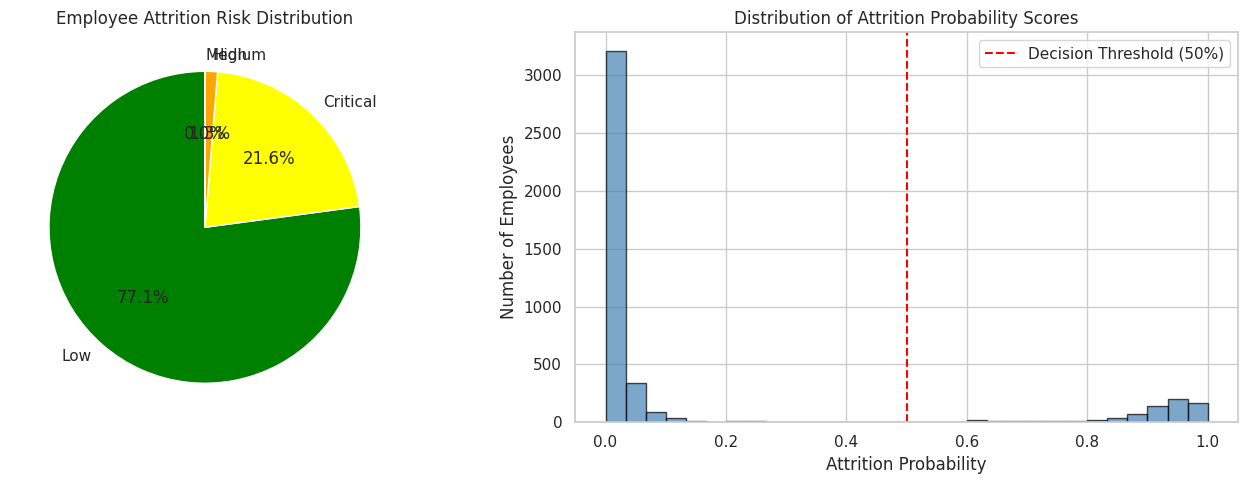

In [206]:
# Visualize risk distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk level pie chart
risk_counts = risk_df['Risk_Level'].value_counts()
colors = ['green', 'yellow', 'orange', 'red']
axes[0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[0].set_title('Employee Attrition Risk Distribution')

# Probability histogram
axes[1].hist(attrition_proba, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (50%)')
axes[1].set_xlabel('Attrition Probability')
axes[1].set_ylabel('Number of Employees')
axes[1].set_title('Distribution of Attrition Probability Scores')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7.7 Summary: Key Insights and Recommendations

In [207]:
# Generate summary report
print("="*70)
print("EMPLOYEE ATTRITION ANALYSIS - FINAL SUMMARY REPORT")
print("="*70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   - Total employees analyzed: {len(df_full)}")
print(f"   - Features used: {len(all_feature_names)}")
print(f"   - Actual attrition rate: {df_full['Attrition'].mean()*100:.1f}%")

print(f"\n🤖 MODEL PERFORMANCE ({best_model_name}):")
print(f"   - Accuracy: {results[best_model_name]['accuracy']*100:.1f}%")
print(f"   - Precision: {results[best_model_name]['precision_yes']*100:.1f}%")
print(f"   - Recall: {results[best_model_name]['recall_yes']*100:.1f}%")
print(f"   - F1-Score: {results[best_model_name]['f1_yes']*100:.1f}%")

print(f"\n🔍 TOP 5 REASONS EMPLOYEES LEAVE:")
for i, row in importance_df.head(5).iterrows():
    print(f"   {importance_df.head(5).index.tolist().index(i)+1}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\n⚠️ AT-RISK EMPLOYEE SUMMARY:")
high_risk = risk_df[risk_df['Risk_Level'].isin(['High', 'Critical'])]
print(f"   - High/Critical risk employees: {len(high_risk)} ({len(high_risk)/len(risk_df)*100:.1f}%)")
print(f"   - Medium risk employees: {len(risk_df[risk_df['Risk_Level']=='Medium'])}")
print(f"   - Low risk employees: {len(risk_df[risk_df['Risk_Level']=='Low'])}")

print(f"\n💡 RECOMMENDATIONS:")
print("   1. Focus retention efforts on High/Critical risk employees")
print("   2. Address top attrition factors (see feature importance chart)")
print("   3. Monitor employees with low tenure and job satisfaction")
print("   4. Consider salary reviews for underpaid high-performers")
print("   5. Implement regular check-ins with at-risk employees")

EMPLOYEE ATTRITION ANALYSIS - FINAL SUMMARY REPORT

📊 DATASET OVERVIEW:
   - Total employees analyzed: 4410
   - Features used: 44
   - Actual attrition rate: 16.1%

🤖 MODEL PERFORMANCE (Random Forest):
   - Accuracy: 99.5%
   - Precision: 100.0%
   - Recall: 97.2%
   - F1-Score: 98.6%

🔍 TOP 5 REASONS EMPLOYEES LEAVE:
   1. Age: 0.0773
   2. MonthlyIncome: 0.0726
   3. TotalWorkingYears: 0.0725
   4. YearsAtCompany: 0.0692
   5. DistanceFromHome: 0.0538

⚠️ AT-RISK EMPLOYEE SUMMARY:
   - High/Critical risk employees: 707 (16.0%)
   - Medium risk employees: 1
   - Low risk employees: 2387

💡 RECOMMENDATIONS:
   1. Focus retention efforts on High/Critical risk employees
   2. Address top attrition factors (see feature importance chart)
   3. Monitor employees with low tenure and job satisfaction
   4. Consider salary reviews for underpaid high-performers
   5. Implement regular check-ins with at-risk employees


In [208]:
# Save the risk assessment to CSV for HR team
risk_df.to_csv("clean_data/employee_attrition_risk.csv", index=False)
print("\n✅ Risk assessment saved to: clean_data/employee_attrition_risk.csv")

# Save the best model for future predictions
import joblib
joblib.dump(best_pipeline, "clean_data/attrition_model.pkl")
print("✅ Best model saved to: clean_data/attrition_model.pkl")


✅ Risk assessment saved to: clean_data/employee_attrition_risk.csv
✅ Best model saved to: clean_data/attrition_model.pkl
